In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
# Displaying routine

def display_images(in_, out, n=1, label=None, count=False, save=False, name='no_name'):
    for N in range(n):
        # plot input images for reconstruction case
        if in_ is not None: 
            in_pic = in_.data.cpu().view(-1, 28, 28) # rearrange image
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='b', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N]) # plot i-th picture
                plt.axis('off')
        # plot reconstructions/ samples
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4): # show 4 samples per row
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='b')
        if save: plt.savefig(name + str(n) + '.pdf')

In [3]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [4]:
from torchvision import datasets, transforms

datasets.MNIST.resources = [
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
]

batch_sz = 256
tr_ = transforms.ToTensor()
# MNIST
train_dataset = datasets.MNIST(
    root='./data', 
    train=True, 
    transform=tr_,  
    download=True
)
# already normalized to [0, 1]
# access images by train_dataset[i][0] and labels with [i][1]

test_dataset = datasets.MNIST(
    root='./data', 
    train=False, 
    transform=tr_  
)

# DataLoader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_sz,
    shuffle=True 
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_sz,
    shuffle=False 
)

In [5]:
# Defining the device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Defining the model

# no dimensions in latent space
d = 20
featureDim = 32*20*20 # no dimensions after convolutions 

class View(nn.Module): # helper for reshaping in deconvolution
    def __init__(self, shape):
        super().__init__()
        
        self.shape = shape
        
    def forward(self, x):
        return x.view(*self.shape) # why '*' ?

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),
            nn.ReLU(),
            # flatten the different kernels
            nn.Flatten(),
            nn.Linear(featureDim, 2 * d)
        )

        # decoder requires sample as input,
        # not just the output of the encoder.

        self.decoder = nn.Sequential(
            nn.Linear(d, featureDim),
            nn.ReLU(),
            # reshape the kernel dimension with own Module
            View((-1, 32, 20, 20)),
            nn.ConvTranspose2d(32, 16, 5), # 'Transpose' for 'deconvolution'
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 5), # 1 image channel
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        # draw sample z in latent space for given parameters
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_() # random! use randn_like(.)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        # propagate image through encoder and decoder.
        # output reconstruction and parameters of distribution over
        # latent representations.
        
        # non convolutional:
        # mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        
        # convolutional:
        mu_logvar = self.encoder(x).view(-1, 2, d)

        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)

In [7]:
# Setting the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

In [8]:
# Reconstruction + β * KL divergence losses summed over all elements and batch
beta_global = 1

def loss_function(x_hat, x, mu, logvar, β=beta_global):
    # reconstruction:
    MSE = nn.functional.mse_loss(x_hat, x, reduction='sum')
    # BCE = nn.functional.binary_cross_entropy(
    #    x_hat, x, reduction='sum')
    
    # strucutre in latent space:
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    
    # print('MSE: ' , MSE)
    # print('KLD: ' , KLD)
    # print('beta:', β)
    
    return MSE + β * KLD

====> Test set loss: 170.0629
====> Epoch: 1 Average loss: 92.4588
====> Test set loss: 93.8748
====> Epoch: 2 Average loss: 88.0660
====> Test set loss: 91.2632
====> Epoch: 3 Average loss: 87.8801
====> Test set loss: 90.4747
====> Epoch: 4 Average loss: 87.8387
====> Test set loss: 90.1317
====> Epoch: 5 Average loss: 87.8249
====> Test set loss: 89.9434
====> Epoch: 6 Average loss: 87.8189
====> Test set loss: 89.8257
====> Epoch: 7 Average loss: 87.8158
====> Test set loss: 89.7449
====> Epoch: 8 Average loss: 87.8141
====> Test set loss: 89.6856
====> Epoch: 9 Average loss: 87.8130
====> Test set loss: 89.6401
====> Epoch: 10 Average loss: 87.8122
====> Test set loss: 89.6041


<ipython-input-2-86188372ba72>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 4))


====> Epoch: 11 Average loss: 87.8117
====> Test set loss: 89.5750
====> Epoch: 12 Average loss: 87.8113
====> Test set loss: 89.5508
====> Epoch: 13 Average loss: 87.8111
====> Test set loss: 89.5304
====> Epoch: 14 Average loss: 87.8109
====> Test set loss: 89.5129
====> Epoch: 15 Average loss: 87.8107
====> Test set loss: 89.4978
====> Epoch: 16 Average loss: 87.8106
====> Test set loss: 89.4844
====> Epoch: 17 Average loss: 87.8105
====> Test set loss: 89.4726
====> Epoch: 18 Average loss: 87.8104
====> Test set loss: 89.4622
====> Epoch: 19 Average loss: 87.8104
====> Test set loss: 89.4529
====> Epoch: 20 Average loss: 87.8103
====> Test set loss: 89.4445
====> Epoch: 21 Average loss: 87.8103
====> Test set loss: 89.4369
====> Epoch: 22 Average loss: 87.8102
====> Test set loss: 89.4300
====> Epoch: 23 Average loss: 87.8102
====> Test set loss: 89.4237
====> Epoch: 24 Average loss: 87.8102
====> Test set loss: 89.4180
====> Epoch: 25 Average loss: 87.8102
====> Test set loss: 89.

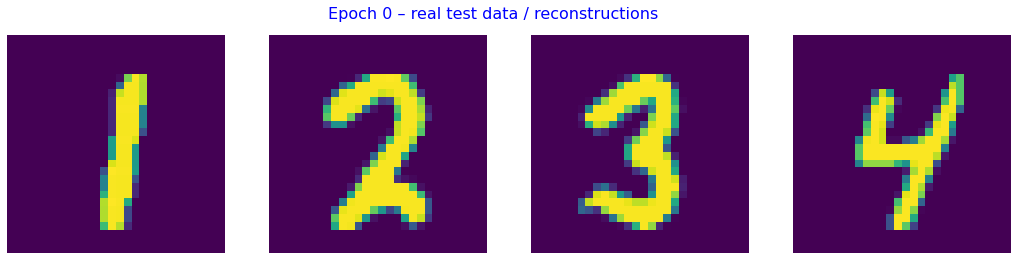

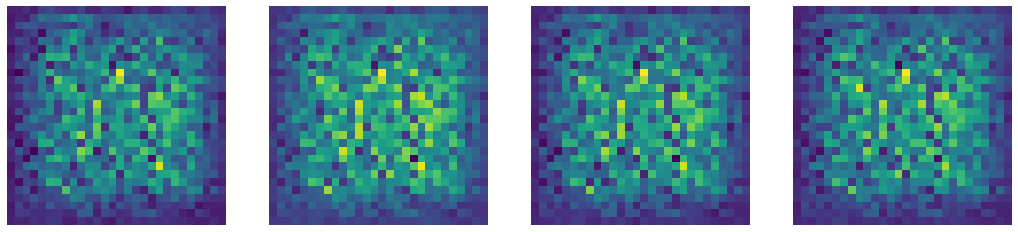

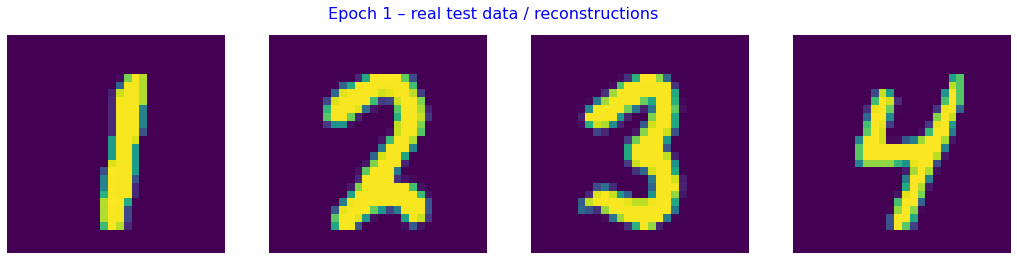

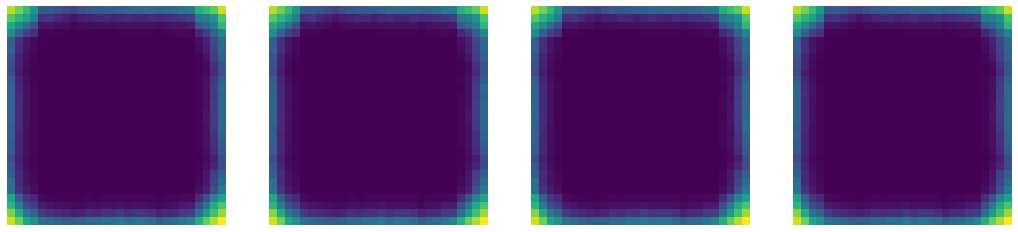

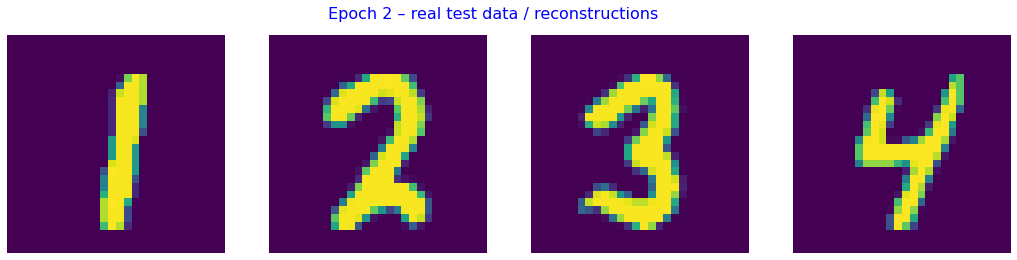

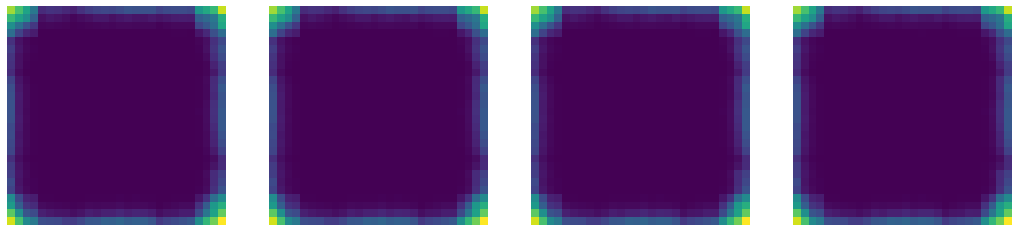

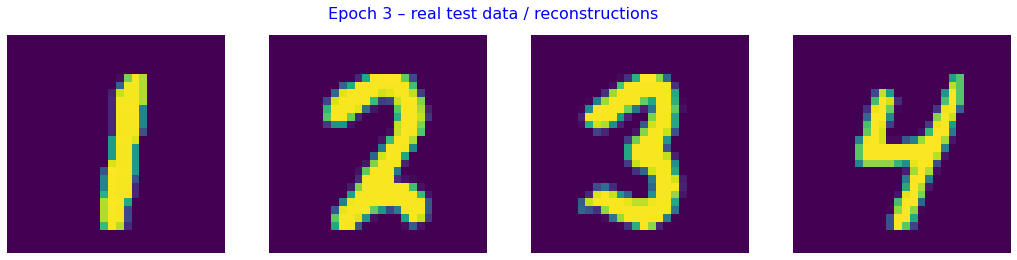

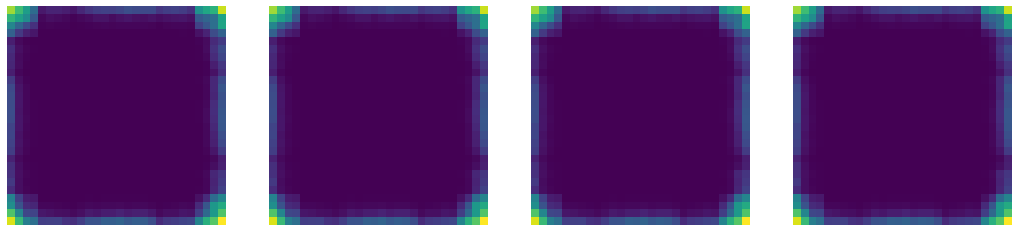

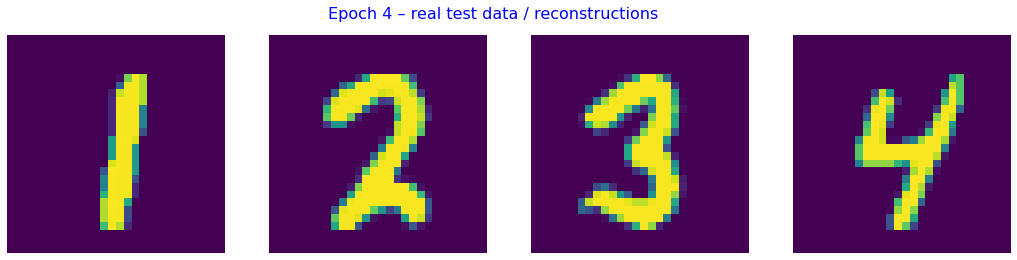

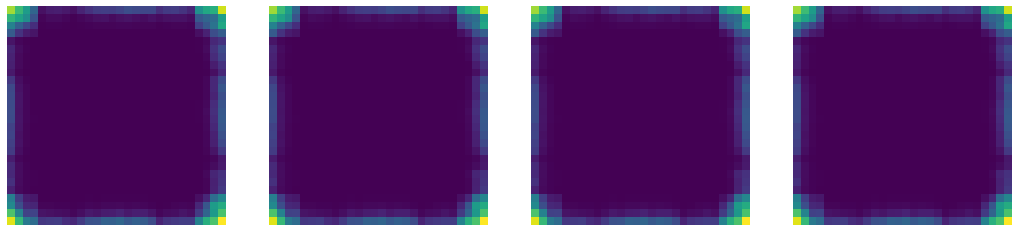

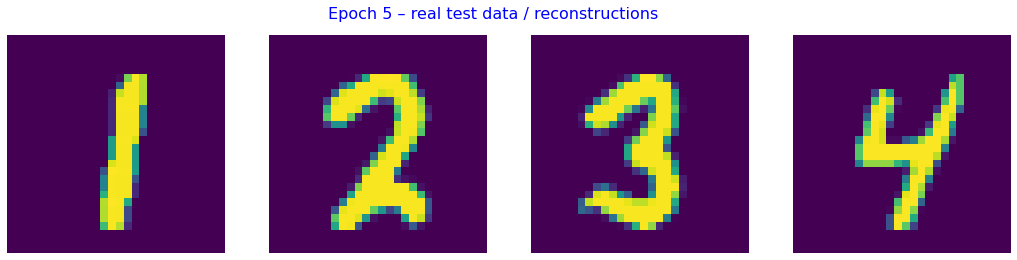

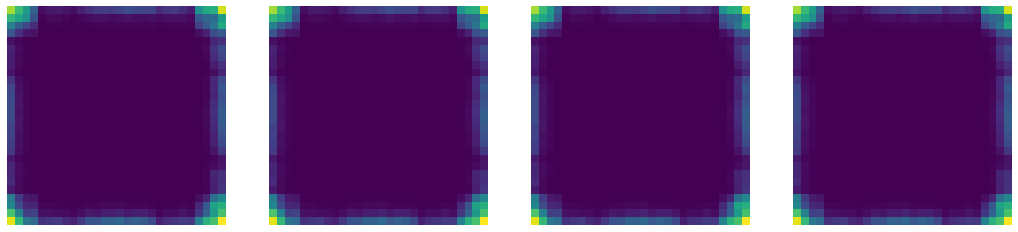

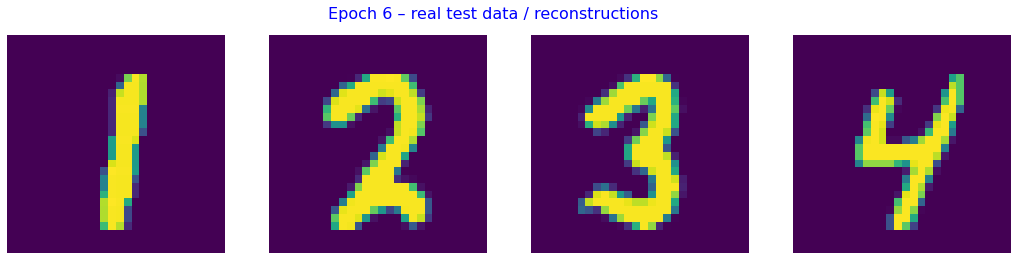

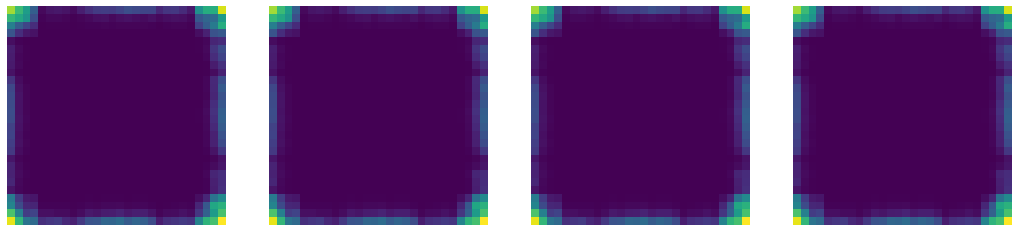

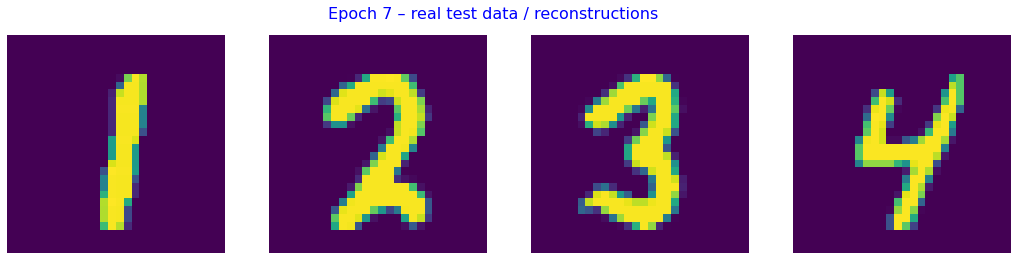

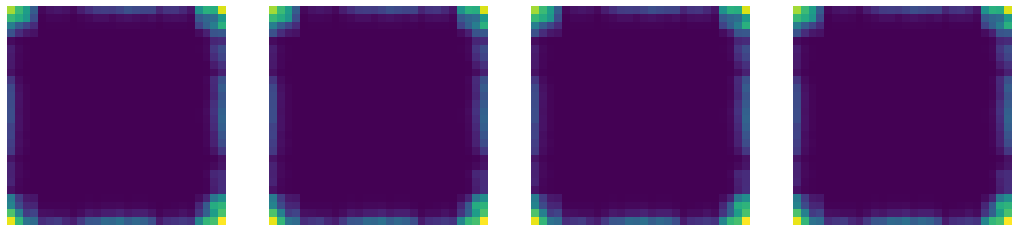

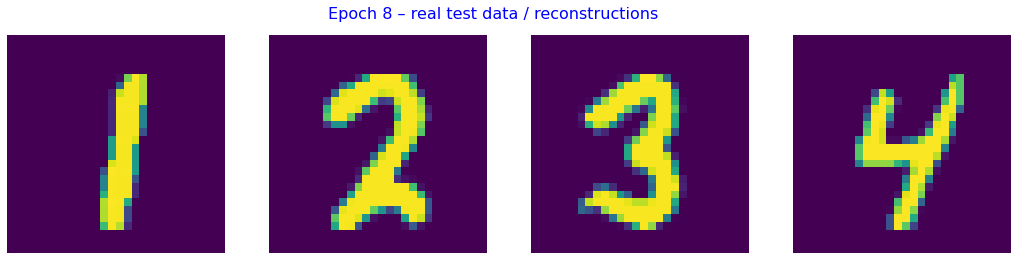

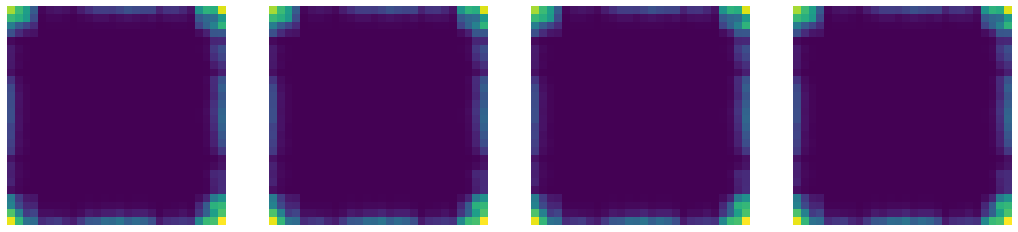

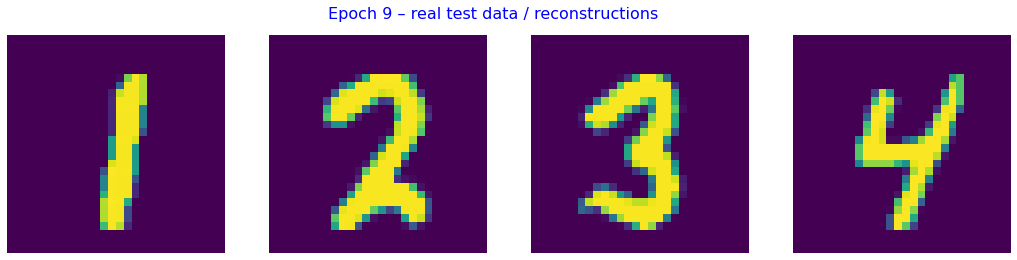

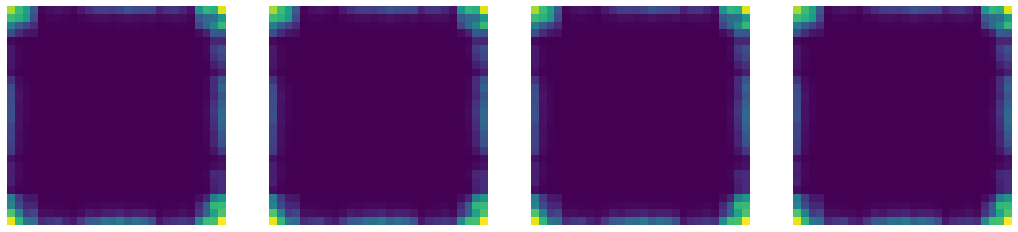

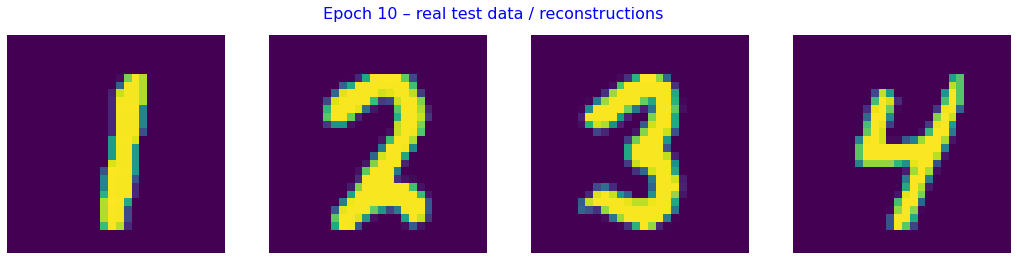

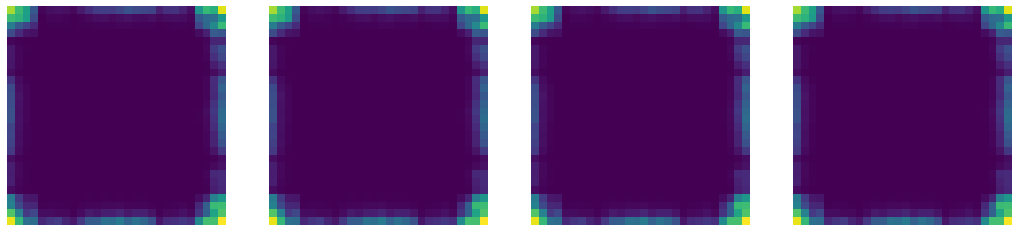

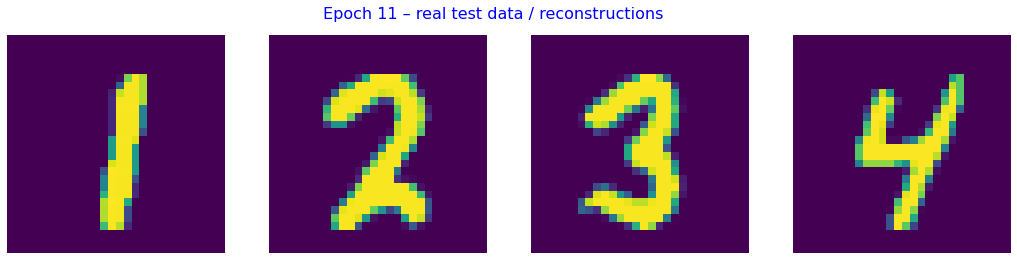

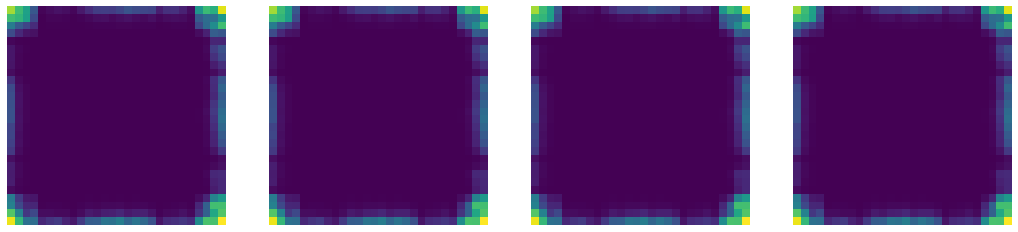

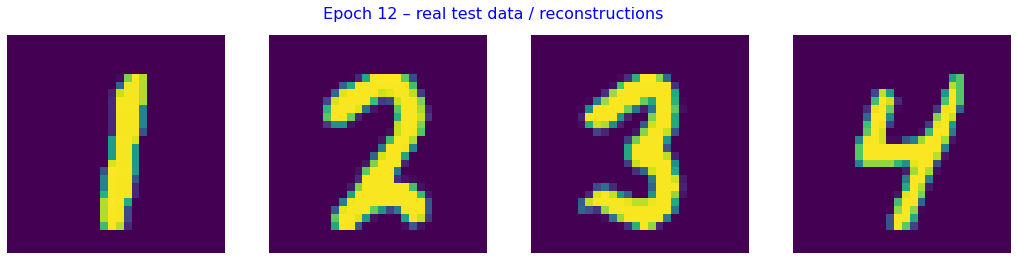

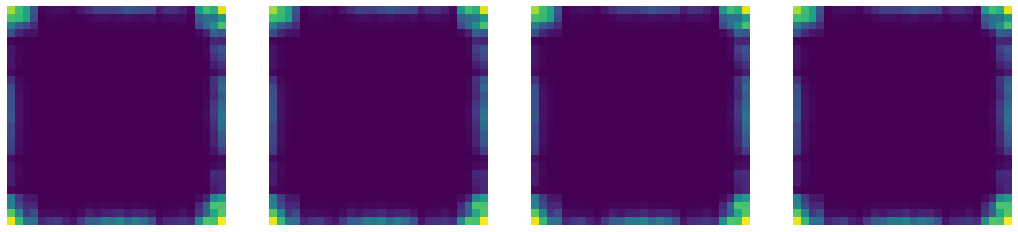

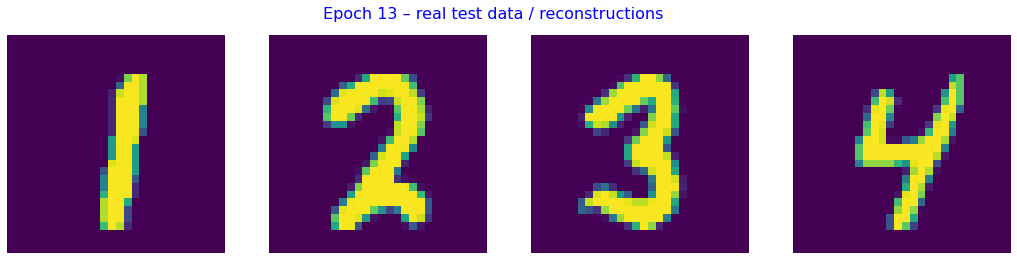

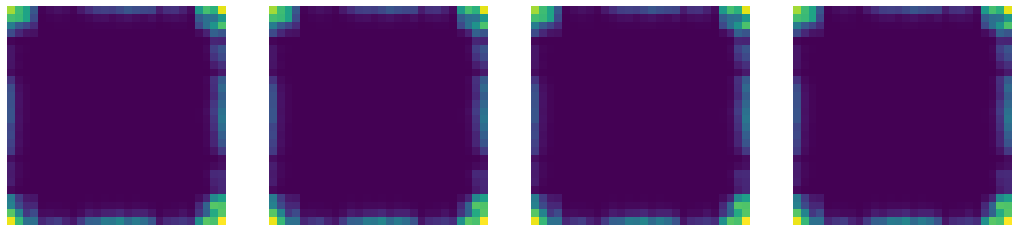

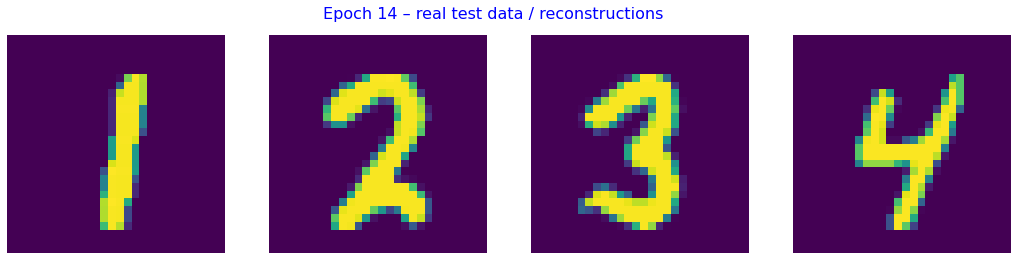

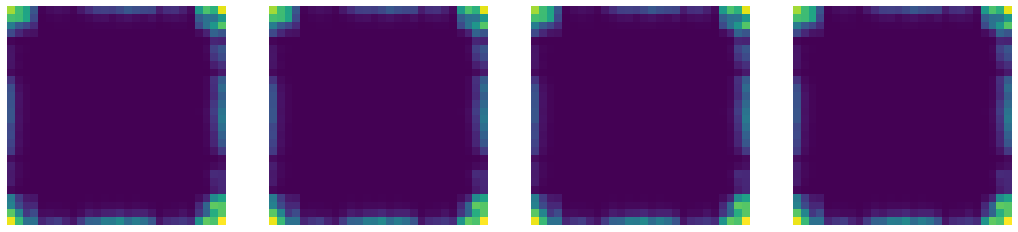

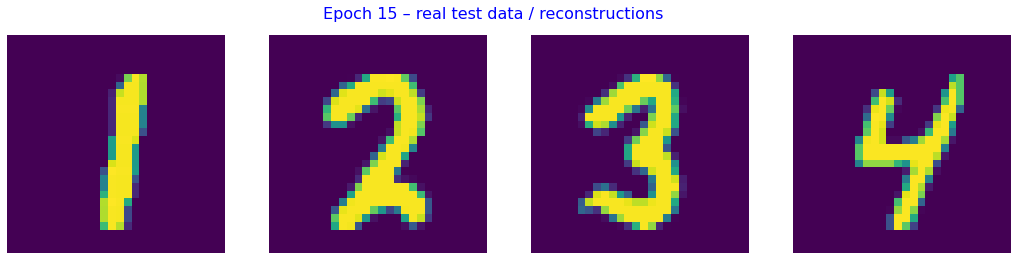

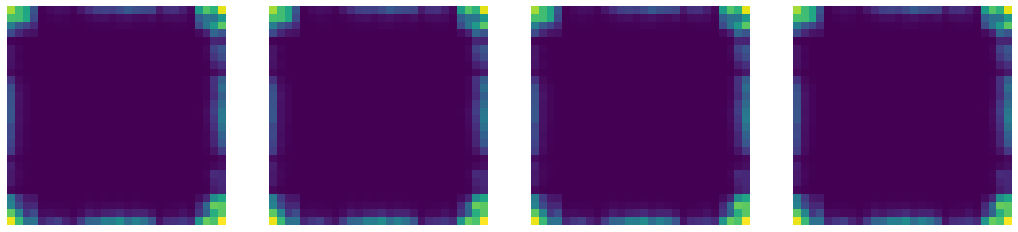

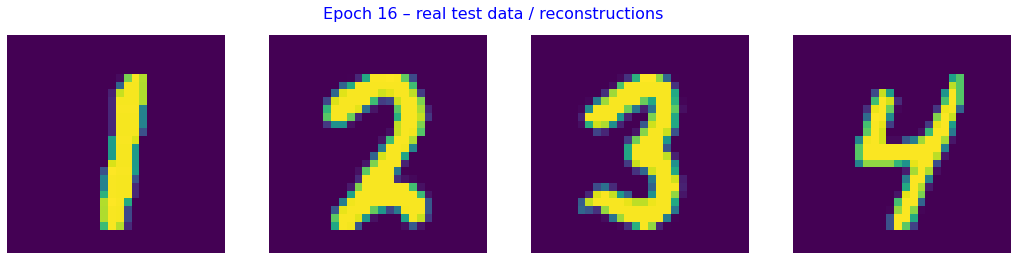

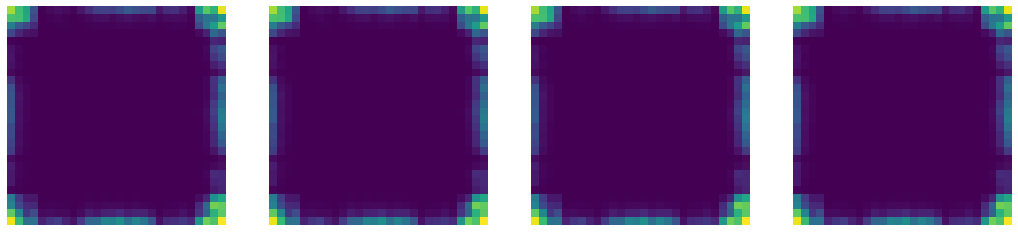

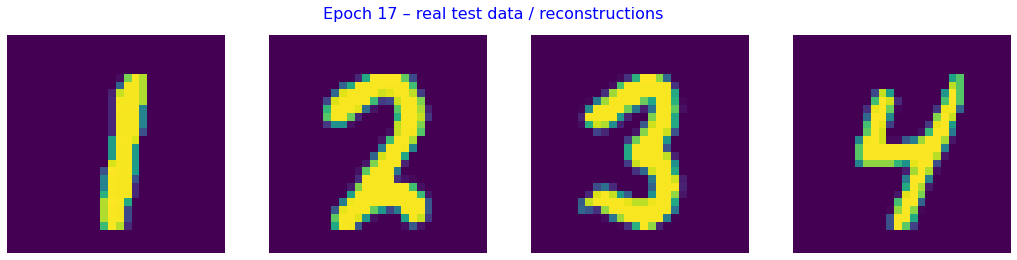

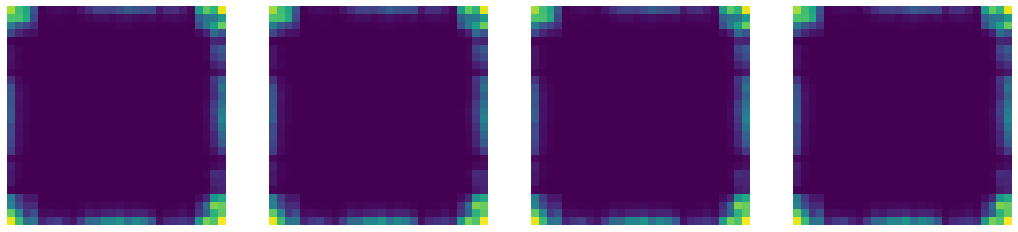

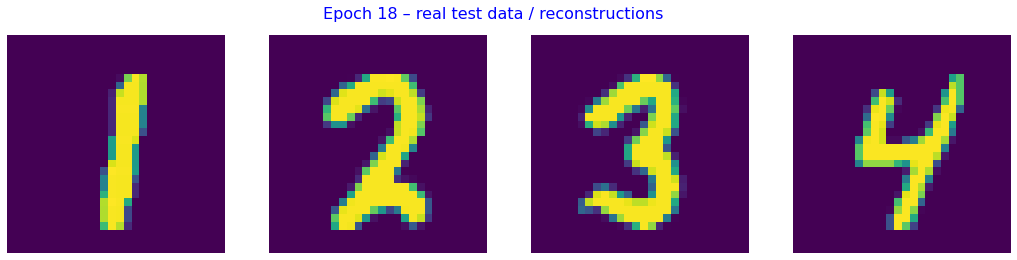

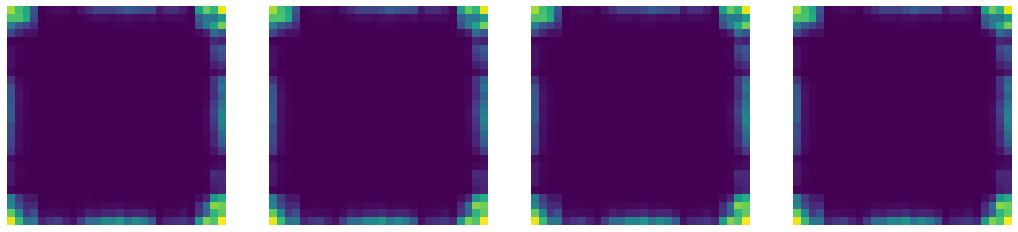

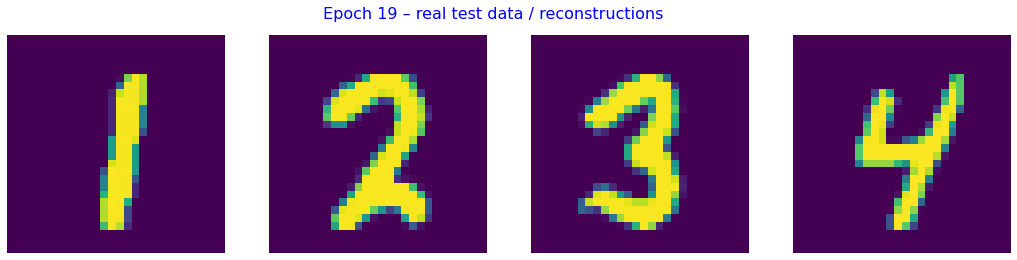

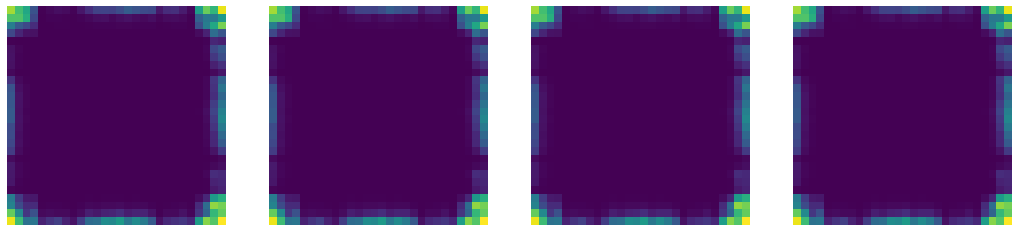

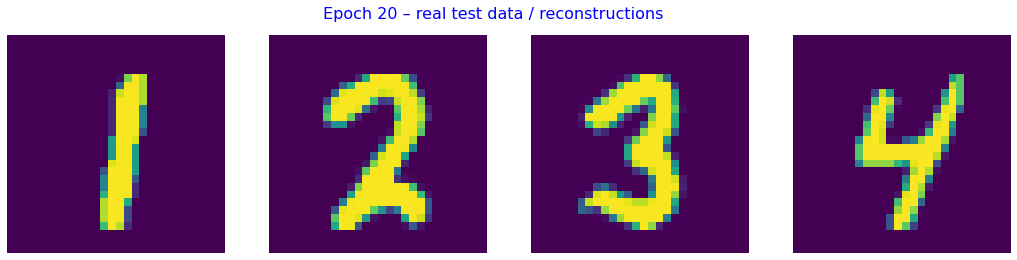

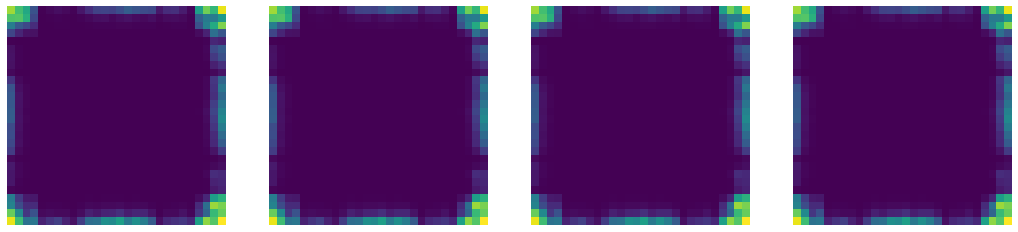

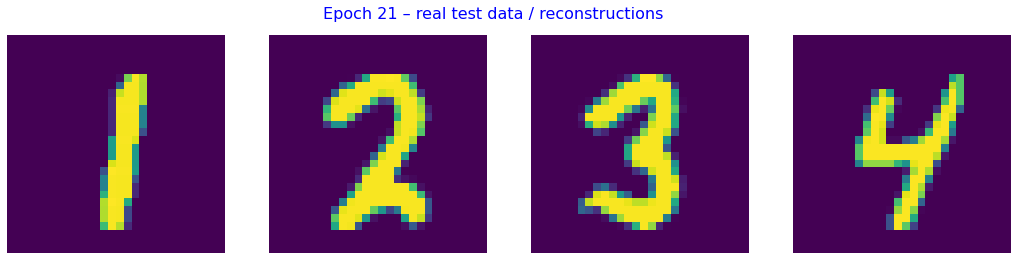

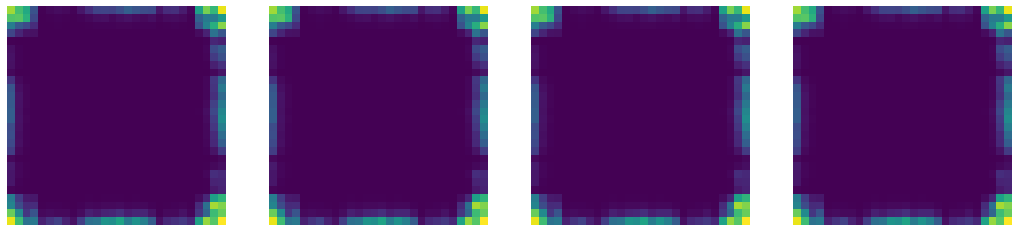

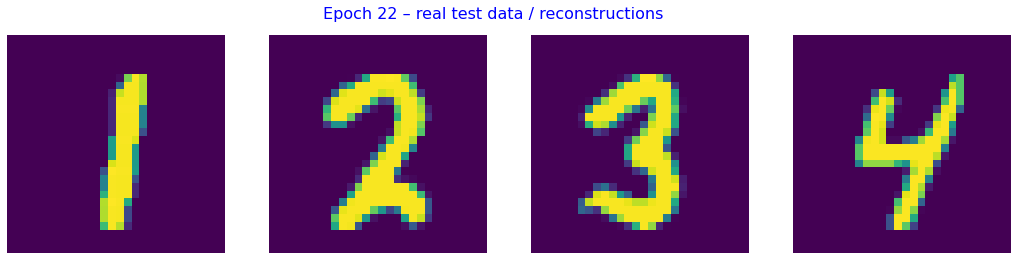

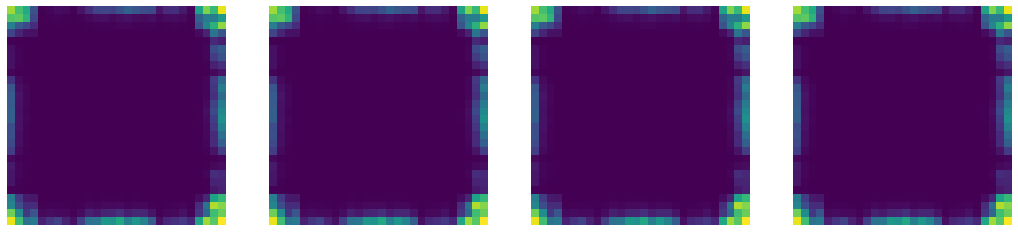

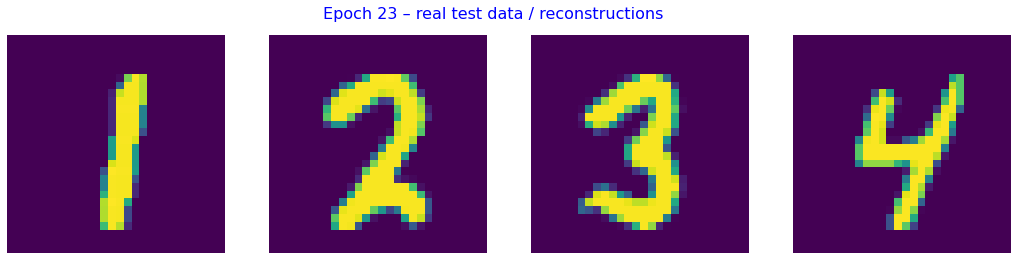

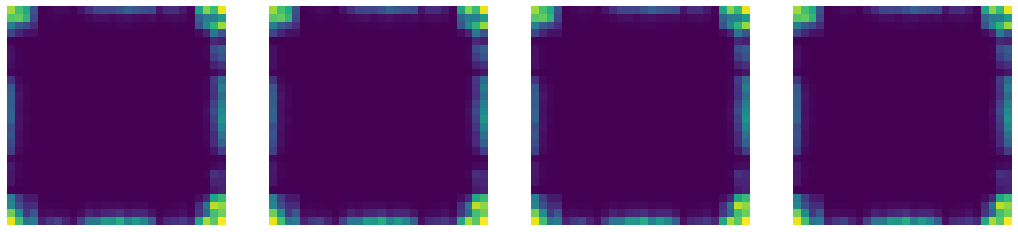

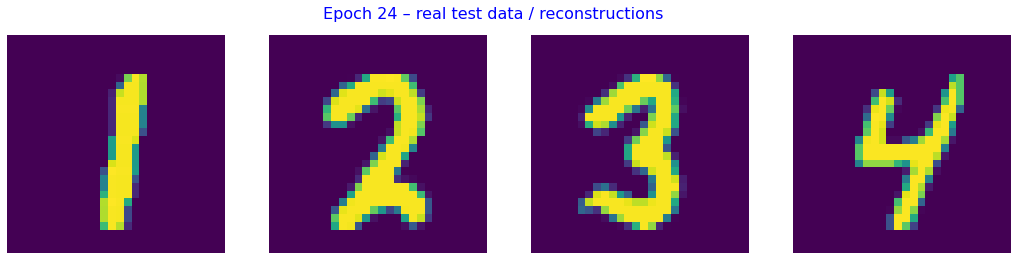

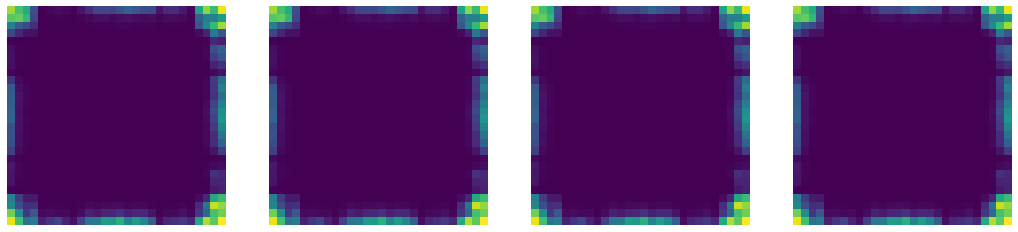

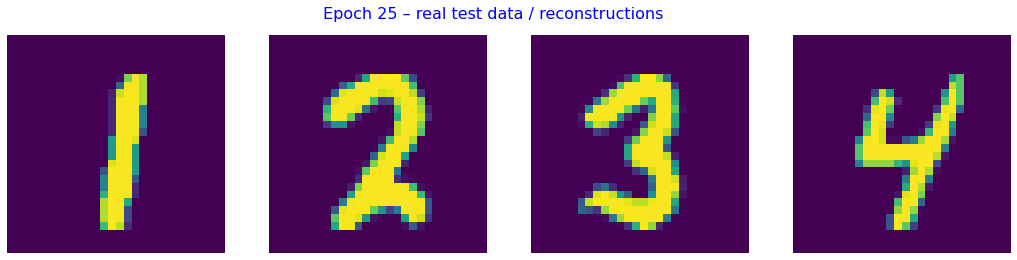

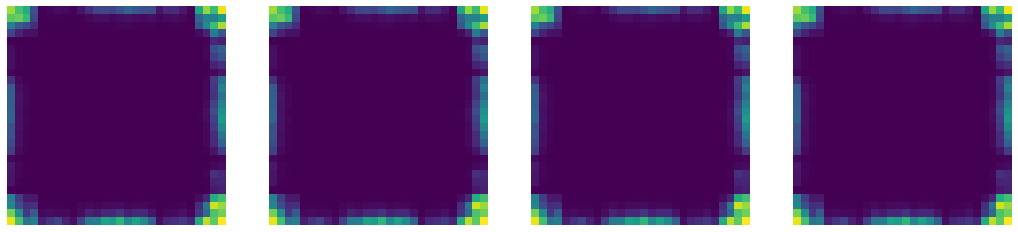

In [9]:
# Training and testing the VAE

epochs = 25
codes = dict(μ=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    
    # Training
    if epoch > 0:  # test untrained net first
        model.train() # set module into training mode
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device) # use loader directly on GPU
            # clear gradient buffer
            optimizer.zero_grad()
            # ===================forward=====================
            x_hat, mu, logvar = model(x) 
            # x_hat is supposed to have shape (batch_size, channels, width, height) for convolutional 
            
            # compute error for this observation
            loss = loss_function(x_hat, x, mu, logvar) # build diff graph
            train_loss += loss.item()
            # ===================backward====================
            # compute gradients and step into opposite direction
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['μ'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_l^oader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

In [10]:
# save model parameters to hard drive @working directory
model_name = 'latDim_' + str(d) + '-epoch_' + str(epoch) + '-beta_' + str(beta_global) + '-lr_' + str(learning_rate) + '-bs_' + str(batch_sz) + '.pt'

In [11]:
torch.save(model.state_dict(), './' + model_name)

In [12]:
# load pretrained model parameters if desired
load = False
if load:
    model = VAE().to(device) # init model object to plug in the params
    model.load_state_dict(torch.load(model_name)) # argument to load_state_dict must be dict, not path
    # set into evaluation mode
    model.eval()

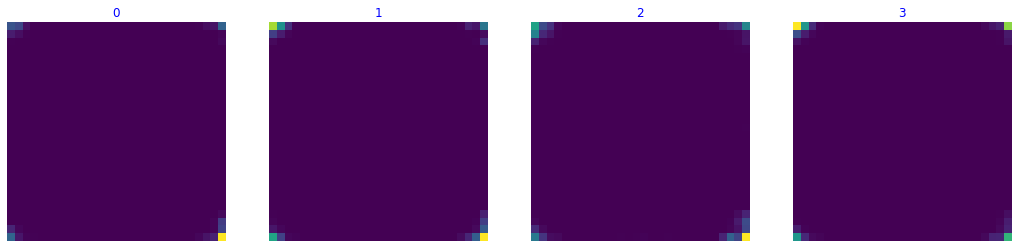

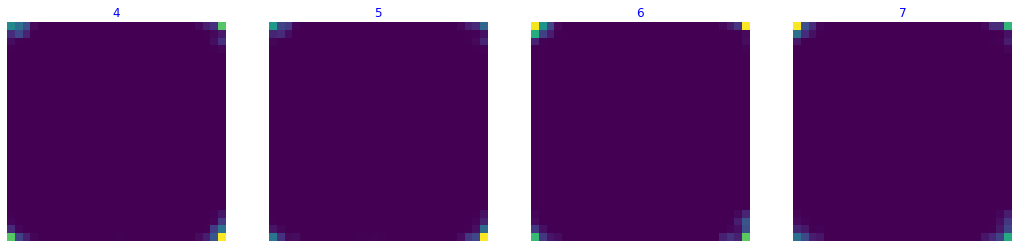

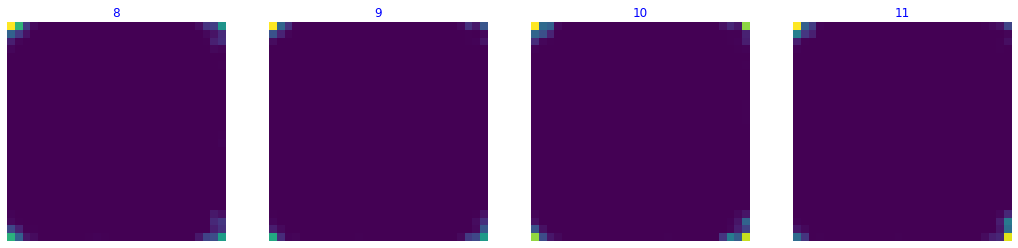

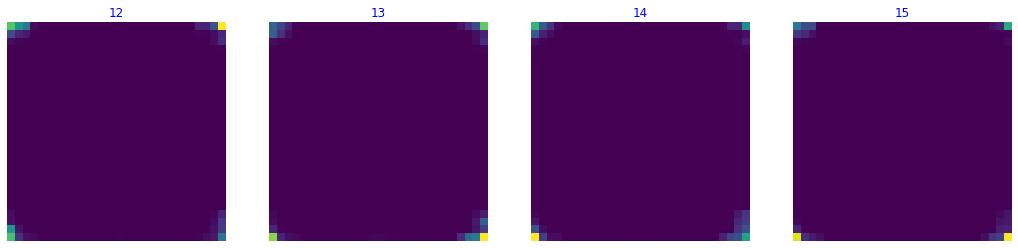

In [13]:
# Generate a few samples
N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
fig_name = 'samples' + model_name.split('.')[0]
display_images(None, sample, N // 4, count=True, save=True, name=fig_name)

# 